In [22]:
"""
# coding: utf-8
@author: Yuhao Zhang
last updated: 05/29/2025
data from: Xinchao Chen
"""
%reset -f
data_path = '/data2/zhangyuhao/xinchao_data/Givenme/1670-2-tremor-Day5-bank_1CVC-FM_g0'
save_path = "/home/zhangyuhao/Desktop/Result/ET/Rastermap/NP2/givenme/1670-2-tremor-Day5-bank_1CVC-FM_g0"

# Load data

In [42]:
import neo
import quantities as pq
import pandas as pd
from ast import literal_eval
from elephant.conversion import BinnedSpikeTrain
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore

fr_bin = 200  # unit: ms
# Load electrophysiology data
ephys_fs = 30000 #spikeGLX neuropixel sample rate
identities = np.load(data_path + '/Sorted/kilosort4/spike_clusters.npy') # time series: unit id of each spike
times = np.load(data_path + '/Sorted/kilosort4/spike_times.npy')  # time series: spike time of each spike
neurons = pd.read_csv(data_path + "/filtered_quality_metrics.csv")  # QC neurons
#neurons = pd.read_csv(data_path + '/Sorted/kilosort4/cluster_group.tsv', sep='\t')  
# Load motion data
motion_fs = 10593.2
marker = pd.read_csv(data_path + "/Marker/static_motion_segement.csv")
motion_data = np.load(data_path + "/Marker/motion_marker.npy")
motion_data = motion_data[0]

elec_length = times[-1] / ephys_fs
behav_length = motion_data.shape[0] / motion_fs
print("Test if electrophysiology duration is equal to motion duration ...")
print(f"Electrophysiology duration: {elec_length}")
print(f"Motion duration: {behav_length}")

Test if electrophysiology duration is equal to motion duration ...
Electrophysiology duration: 1029.8375
Motion duration: 1029.8364988860778


# Get data format for RasterMap: neurons * spike counts

In [24]:
def singleneuron_spiketimes(id):
    x = np.where(identities == id)
    y=x[0]
    spike_times=np.zeros(len(y))
    for i in range(0,len(y)):
        z=y[i]
        spike_times[i]=times[z]/ephys_fs
    return spike_times

def neuron_spikecounts(neuron_id,marker_start,marker_end):
    spike_times = singleneuron_spiketimes(neuron_id)
    spike_times_trail = spike_times[(spike_times > marker_start) & (spike_times < marker_end)]
    spiketrain = neo.SpikeTrain(spike_times_trail,units='sec',t_start=marker_start, t_stop=marker_end)
    fr = BinnedSpikeTrain(spiketrain, bin_size=fr_bin*pq.ms,tolerance=None)  # had been qualified that elephant can generate correct spike counts
    trial_neuron_fr = fr.to_array().astype(int)[0]
    return trial_neuron_fr

def popu_spikecounts(start,end):
    for index, row in neurons.iterrows():
        unit_id = row['cluster_id']
        spikecount = neuron_spikecounts(unit_id,start,end)
        if index == 0:
            all_spikecounts = np.array([spikecount])
        else:
            all_spikecounts = np.vstack((all_spikecounts, spikecount))
    return all_spikecounts

spks = popu_spikecounts(0,elec_length)
n_neurons, n_time = spks.shape
print(f"{n_neurons} neurons by {n_time} timepoints")
# zscore activity (each neuron activity trace is then mean 0 and standard-deviation 1)
spks = zscore(spks, axis=1)

/home/zhangyuhao/miniconda3/envs/ET/lib/python3.12/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/zhangyuhao/miniconda3/envs/ET/lib/python3.12/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/zhangyuhao/miniconda3/envs/ET/lib/python3.12/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/zhangyuhao/miniconda3/envs/ET/lib/python3.12/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


105 neurons by 5149 timepoints


# Run RasterMap

In [35]:
model = Rastermap(n_clusters=5, # None turns off clustering and sorts single neurons 
                  n_PCs=64, # use fewer PCs than neurons
                  locality=0.1, # some locality in sorting (this is a value from 0-1)
                  time_lag_window=15, # use future timepoints to compute correlation
                  grid_upsample=0, # 0 turns off upsampling since we're using single neurons
                ).fit(spks)
y = model.embedding # neurons x 1
isort = model.isort

2025-05-29 12:09:04,607 [INFO] normalizing data across axis=1
2025-05-29 12:09:04,617 [INFO] projecting out mean along axis=0
2025-05-29 12:09:04,629 [INFO] data normalized, 0.02sec
2025-05-29 12:09:04,631 [INFO] sorting activity: 105 valid samples by 5149 timepoints
2025-05-29 12:09:04,736 [INFO] n_PCs = 64 computed, 0.13sec
2025-05-29 12:09:04,744 [INFO] 5 clusters computed, time 0.14sec
2025-05-29 12:09:04,752 [INFO] clusters sorted, time 0.14sec
2025-05-29 12:09:04,765 [INFO] rastermap complete, time 0.16sec


# Compute tuning curve

In [49]:
window_size = int(round(motion_fs * 0.2))  # 计算窗口样本数，2119
# 计算可分割的窗口数量
num_windows = len(motion_data) // window_size
truncated_data = motion_data[:num_windows * window_size]
sums = truncated_data.reshape(num_windows, window_size).sum(axis=1)
motion_signed = sums - sums.mean()
motion_signed = np.append(motion_signed, 0)
#motion_signed  = zscore(motion_signed)
# Normalize motion_signed to range [-1, 1]
motion_signed = 2 * (motion_signed - motion_signed.min()) / (motion_signed.max() - motion_signed.min()) - 1
# Compute the difference between adjacent elements in motion_signed
motion_signed_dif = np.diff(motion_signed)
motion_signed_dif = np.insert(motion_signed_dif, 0, 0)

n_pos = 15
bins = np.arange(-1, 1+1./n_pos, 1./n_pos)
ibin = np.digitize(motion_signed, bins) - 1
n_bins = ibin.max()
inan = np.isnan(motion_signed)
ibin[inan] = -1
tcurves = np.zeros((spks.shape[0], n_bins))
for b in range(n_bins):
    tcurves[:, b] = spks[:, ibin==b].mean(axis=1)
tcurves -= tcurves.mean(axis=1, keepdims=True)

# Plot

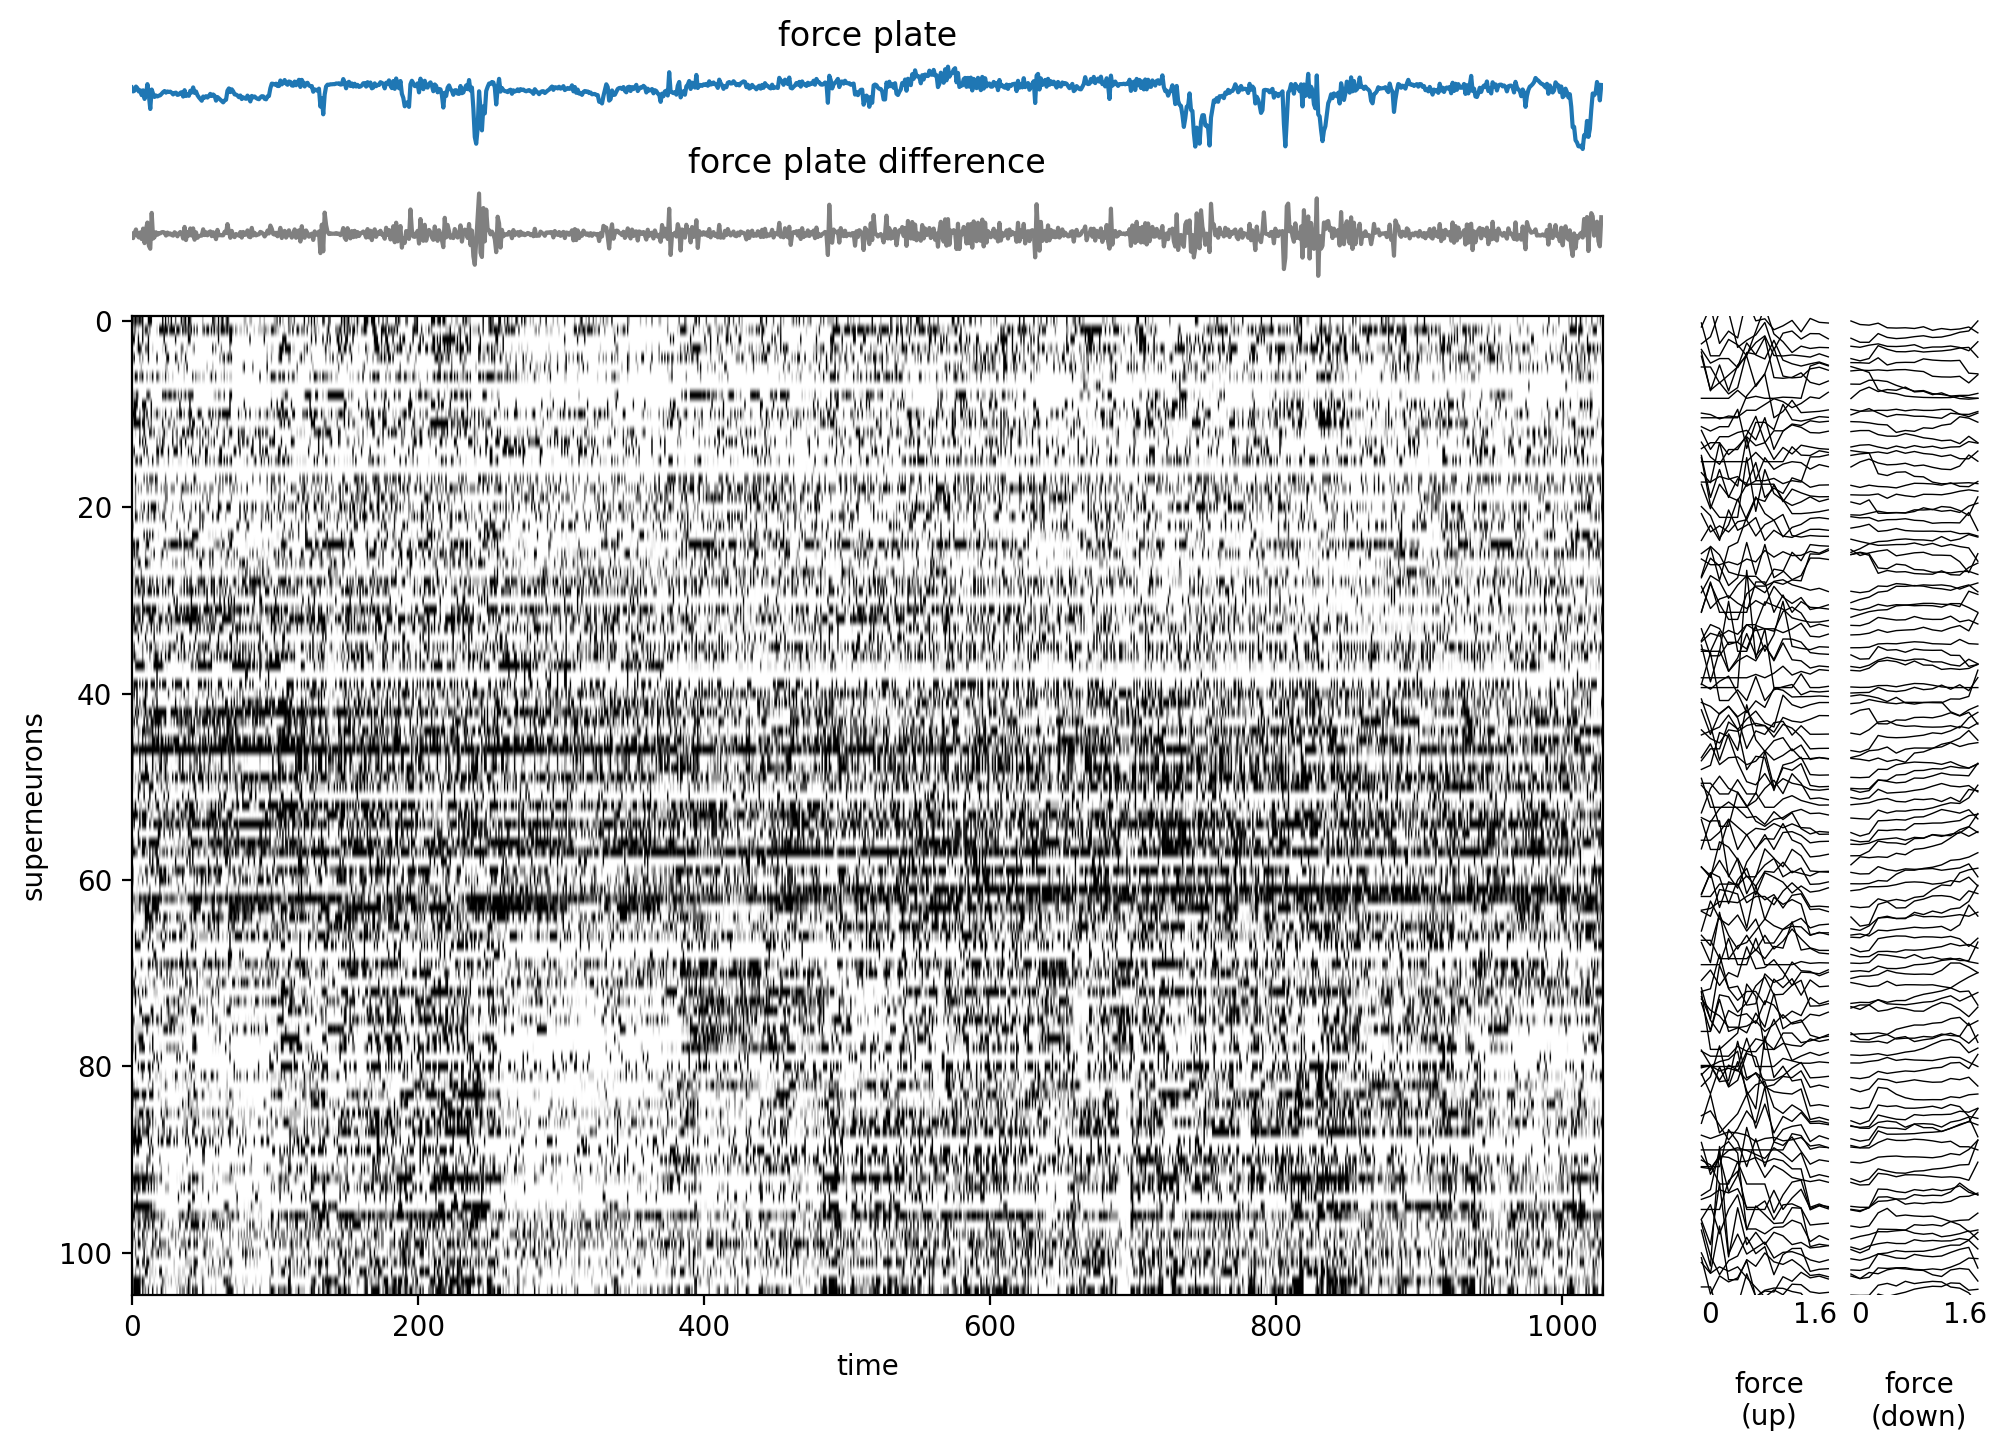

In [50]:
'''
# visualize binning over neurons
X_embedding = model.X_embedding
# plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=1.5, cmap="gray_r", aspect="auto")
'''

# timepoints to visualize
xmin = 0
xmax = int(elec_length)

# make figure with grid for easy plotting
fig = plt.figure(figsize=(12,8), dpi=200)
grid = plt.GridSpec(10, 24, figure=fig, wspace = 0.1, hspace = 0.4)

# plot motion
ax = plt.subplot(grid[0, :-5])
ax.plot(motion_signed[xmin:xmax])#, color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("force plate")

# plot motion difference
ax = plt.subplot(grid[1, :-5])
ax.plot(motion_signed_dif[xmin:xmax], color=0.5*np.ones(3))
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("force plate difference")

# plot sorted neural activity
ax = plt.subplot(grid[2:, :-5])
ax.imshow(spks[isort, xmin:xmax], cmap="gray_r", vmin=0, vmax=1.2, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

# plot single-neuron tuning curves
ax = plt.subplot(grid[2:, -4:])
x = np.arange(0, n_pos)
dy = 2
xpad = n_pos/10
nn = spks.shape[0]
for t in range(len(tcurves)):
    ax.plot(x, tcurves[isort[t], :n_pos]*dy - dy/2 + nn - t, 
            color="k", lw=0.5)
    ax.plot(x+n_pos+xpad, tcurves[isort[t], n_pos:]*dy - dy/2 + nn - t, 
            color="k", lw=0.5)
for j in range(2):
    xstr = "force\n(up)" if j==0 else "force\n(down)"
    ax.text(n_pos/2 + j*(n_pos+xpad), -14, xstr, ha="center")
    ax.text(j*(n_pos+xpad), -3, "0")
    ax.text(n_pos + j*(n_pos+xpad), -3, "1.6", ha="right")
ax.set_ylim([0, nn])
ax.axis("off")
fig.savefig(save_path + "/rastermap.png", bbox_inches="tight", dpi=200)